# Initial steps

In [1]:
!nvidia-smi

Tue Jun 20 00:48:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from transformers import TFBertModel, BertTokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = True

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
def custom_tokenizer(sentences, tokenizer, seq_len):
    '''
    This function takes all input sentences and creates a batch of tokens.
    The batch size is same as the number of inputs.
    We truncate all inpnut_ids of length greater than seq_len. We will not split large texts
    '''

    batch_size = len(sentences)
    input_ids = []
    attention_mask = []

    for sentence in sentences:

        tokens = tokenizer.tokenize(sentence.numpy().decode()) # reading the text
        tokens = ['[CLS]']+tokens+['[SEP]'] # prepending and appending with classification and seperator tokens

        temp_input_ids = tokenizer.convert_tokens_to_ids(tokens) # create temporary list of input_ids

        while len(temp_input_ids) > seq_len: # Truncation
            sep = input_ids.pop()
            input_ids[-1] = sep

        temp_attention_mask = [1]*len(temp_input_ids) # create temporary attention mask

        while len(temp_input_ids) < seq_len: # Padding
            temp_input_ids.append(0)
            temp_attention_mask.append(0)

        input_ids = input_ids + temp_input_ids
        attention_mask = attention_mask + temp_attention_mask

    input_ids = tf.reshape(tf.convert_to_tensor(input_ids),[batch_size,seq_len])
    attention_mask = tf.reshape(tf.convert_to_tensor(attention_mask),[batch_size,seq_len])

    return input_ids, attention_mask # We are passing 2 separate tensors


# Creating the model

In [32]:
seq_len = 256

input_ids = Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')

pooled_output = bert_model([input_ids,attention_mask])
dropout_layer_1 = Dropout(0)(pooled_output[1])

hidden_layer_1 = Dense(128,activation='relu',name = 'hidden_layer_1')(dropout_layer_1)
dropout_layer_2 = Dropout(0.05)(hidden_layer_1)

hidden_layer_2 = Dense(64,activation='relu',name = 'hidden_layer_2')(dropout_layer_2)
dropout_layer_3 = Dropout(0.05)(hidden_layer_2)

classification_layer=Dense(3,activation=tf.nn.softmax, name = 'output_layer')(dropout_layer_2)

simple_model = tf.keras.Model(inputs=[input_ids,attention_mask], outputs=classification_layer)

simple_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [33]:
simple_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

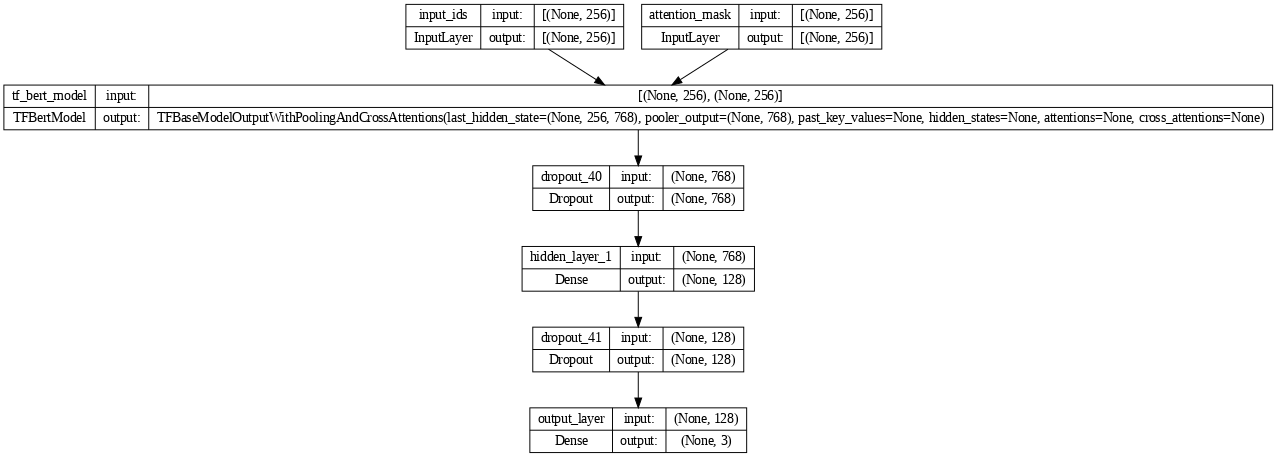

In [34]:
tf.keras.utils.plot_model(model= simple_model, show_shapes=True, dpi = 70)

# Loading and preprocessing the data

In [9]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.2 MB/s eta 0:00:00


In [10]:
from datasets import load_dataset

dataset = load_dataset("financial_phrasebank",'sentences_66agree',split='train')

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


In [11]:
dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4217
})

In [12]:
df=pd.DataFrame(dataset)
df=df.rename(columns={'label':'target'})
df.head()

,sentence,target
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,With the new production plant the company woul...,2
3,According to the company 's updated strategy f...,2
4,"For the last quarter of 2010 , Componenta 's n...",2


In [13]:
sentiment_counts = df['target'].value_counts()
print(sentiment_counts)

1    2535
2    1168
0     514
Name: target, dtype: int64


In [14]:
flag = 0
i=387
while flag ==0 and i < len(df)-1:
  i += 1
  if df.iloc[i].target == 0:
    flag = 1
print(i)

471


In [15]:
df.iloc[471].sentence

'Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .'

In [35]:
#0 = negative, 1 = neutral, 2 = positive
train_df, remaining = train_test_split(df, train_size = 0.8, stratify = df.target.values,shuffle=True,random_state = 3274)
valid_df , test_df = train_test_split(remaining, train_size = 0.5, stratify=remaining.target,shuffle=True,random_state = 1823)

In [36]:
sentiment_counts = [train_df['target'].value_counts(),valid_df['target'].value_counts(),test_df['target'].value_counts()]
print(sentiment_counts)

[1    2028
2     934
0     411
Name: target, dtype: int64, 1    253
2    117
0     52
Name: target, dtype: int64, 1    254
2    117
0     51
Name: target, dtype: int64]


In [38]:
X_train = tf.constant(train_df['sentence'])
y_train = train_df['target']
X_val = tf.constant(valid_df['sentence'])
y_val = valid_df['target']
X_test = tf.constant(test_df['sentence'])
y_test = test_df['target']

In [39]:
train_input = custom_tokenizer(X_train,tokenizer,seq_len)
val_input = custom_tokenizer(X_val,tokenizer,seq_len)
test_input = custom_tokenizer(X_test,tokenizer,seq_len)

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids':train_input[0],'attention_mask':train_input[1]},y_train))
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids':val_input[0],'attention_mask':val_input[1]},y_val))
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids':test_input[0],'attention_mask':test_input[1]},y_test))

'''
We will cache, shufflem batch and prefetch
'''

batch_size = 16

train_dataset = train_dataset.shuffle(buffer_size=1000).cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [41]:
simple_model.compile(optimizer=tf.keras.optimizers.Adam(5e-6), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [42]:
epoch = 6
history = simple_model.fit(train_dataset, validation_data = val_dataset, epochs = epoch, verbose = 1)

Epoch 1/6
211/211 [==============================] - 240s 882ms/step - loss: 0.4327 - accuracy: 0.8438 - val_loss: 0.1433 - val_accuracy: 0.9502
Epoch 2/6
211/211 [==============================] - 185s 876ms/step - loss: 0.1003 - accuracy: 0.9742 - val_loss: 0.1114 - val_accuracy: 0.9645
Epoch 3/6
211/211 [==============================] - 182s 863ms/step - loss: 0.0638 - accuracy: 0.9822 - val_loss: 0.1285 - val_accuracy: 0.9597
Epoch 4/6
211/211 [==============================] - 182s 864ms/step - loss: 0.0362 - accuracy: 0.9920 - val_loss: 0.1479 - val_accuracy: 0.9550
Epoch 5/6
211/211 [==============================] - 182s 863ms/step - loss: 0.0329 - accuracy: 0.9911 - val_loss: 0.1863 - val_accuracy: 0.9479
Epoch 6/6
211/211 [==============================] - 182s 863ms/step - loss: 0.0231 - accuracy: 0.9941 - val_loss: 0.1682 - val_accuracy: 0.9526


In [29]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

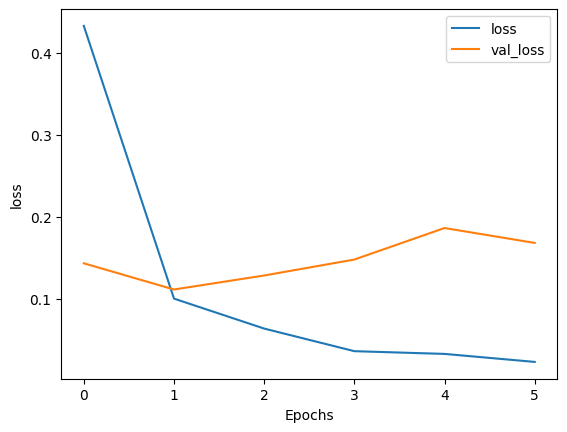

In [43]:
plot_graphs(history,'loss')

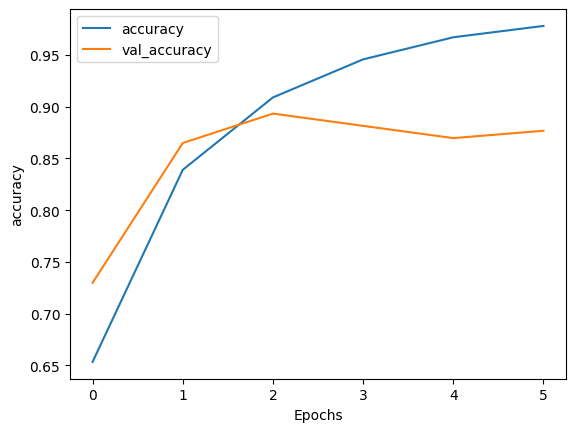

In [31]:
plot_graphs(history,'accuracy')

In [34]:
history_df=history.history

In [83]:
losses = losses+history.history['loss']

In [84]:
val_losses = val_losses+history.history['val_loss']

In [85]:
accuracies = accuracies+history.history['accuracy']

In [86]:
val_accuracies = val_accuracies+history.history['val_accuracy']

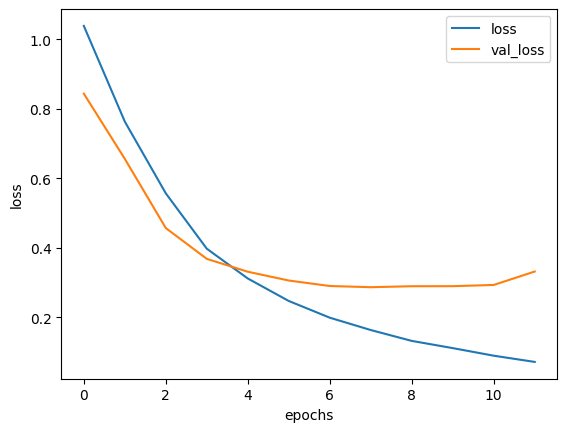

In [87]:
plt.plot(losses,label='loss')
plt.plot(val_losses,label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

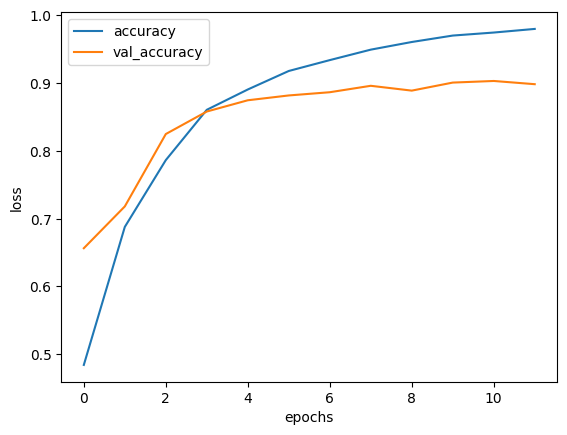

In [88]:
plt.plot(accuracies,label='accuracy')
plt.plot(val_accuracies,label = 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Executing on sample examples

In [44]:
sample_sentences = tf.constant(['The profit declined by 50 % compared to last year.', 'The stock price remained same.', 'The profit in 2023 was 200% higher than that in 2022'])
sample_input = custom_tokenizer(sample_sentences,tokenizer, seq_len)

simple_model.predict(sample_input)

1/1 [==============================] - 3s 3s/step


array([[9.9401528e-01, 3.0675943e-03, 2.9170921e-03],
       [9.1894047e-04, 9.9834132e-01, 7.3976524e-04],
       [2.4731015e-03, 7.0624426e-04, 9.9682069e-01]], dtype=float32)

# Testing performance of model on test data

In [45]:
predictions=simple_model.predict(test_dataset)

27/27 [==============================] - 12s 298ms/step


In [46]:
print(predictions[0], np.argmax(predictions[0]))

[0.9948515  0.00362778 0.0015207 ] 0


In [47]:
y_pred = [np.argmax(pred) for pred in predictions]

In [48]:
y_pred[0:10]

[0, 1, 1, 2, 1, 1, 0, 1, 1, 1]

In [49]:
y_test.iloc[5]

1

### Accuracy of classification

confusion_matrix[i,j]  = count(true label = i, predicted label = j)

In [50]:
confusion_matrix = np.zeros(shape=(3,3))

In [51]:
for n in range(len(y_test)):
  col = y_pred[n]
  row = y_test.iloc[n]
  confusion_matrix[row,col] += 1

In [52]:
confusion_matrix

array([[ 49.,   2.,   0.],
       [  2., 248.,   4.],
       [  4.,   6., 107.]])

In [53]:
accuracy = np.sum([confusion_matrix[i,i] for i in range(3)])/np.sum(confusion_matrix)
print(accuracy)

0.957345971563981


In [56]:
extreme_error_prob = (confusion_matrix[0,2]+confusion_matrix[2,0])/(confusion_matrix[0,0]+confusion_matrix[2,2])

In [57]:
print(f"Probability that the model classifies negative as positive and vice-versa = {extreme_error_prob}")

Probability that the model classifies negative as positive and vice-versa = 0.02564102564102564


# Saving and exporting the model

In [58]:
from google.colab import drive

In [59]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
simple_model.save_weights('/content/drive/MyDrive/tf_models/FSAB_05_25_2023_weights')

Creating another model and loading weights.

In [ ]:
seq_len = 256

input_ids = Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')

pooled_output = bert_model([input_ids,attention_mask])
dropout_layer = Dropout(0.2)(pooled_output[1])

hidden_layer = Dense(128,activation='relu',name = 'hidden_layer')(dropout_layer)
dropout_layer_2 = Dropout(0.2)(hidden_layer)

classification_layer=Dense(3,activation=tf.nn.softmax, name = 'output_layer')(dropout_layer_2)

new_model = tf.keras.Model(inputs=[input_ids,attention_mask], outputs=classification_layer)

new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
new_model.load_weights()